In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Tue Jun 27 22:56:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   28C    P8    13W / 230W |    475MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Hyperparams

In [3]:
n_mels = 16
n_outputs = 61
n_frames = 400

### Model

In [4]:
from model.model_conv_flow import Model
from utils.util import *
from tensorboardX import SummaryWriter

step = 0
device = 'cuda:0'

# Model
model = Model(channels=n_outputs, cond_channels=n_mels, hidden_channels=128, n_layers=4)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
print('done')

done


### Load

In [5]:
save_dir = '/data/scpark/save/lips/train06.27-2/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if True:
    step, model, _, optimizer = load(save_dir, 17000, model, None, optimizer)

total 75332
-rw-rw-r-- 1 scpark scpark       0  6월 27 22:52 events.out.tfevents.1687873955.GPUSVR01
-rw-rw-r-- 1 scpark scpark       0  6월 27 22:52 events.out.tfevents.1687873949.GPUSVR01
-rw-rw-r-- 1 scpark scpark    8980  6월 27 22:47 events.out.tfevents.1687847704.GPUSVR01
-rw-rw-r-- 1 scpark scpark 4283893  6월 27 22:38 save_17000
-rw-rw-r-- 1 scpark scpark 4283893  6월 27 21:41 save_16000
-rw-rw-r-- 1 scpark scpark 4283893  6월 27 20:42 save_15000
-rw-rw-r-- 1 scpark scpark 4283893  6월 27 20:00 save_14000
-rw-rw-r-- 1 scpark scpark 4283893  6월 27 19:14 save_13000
-rw-rw-r-- 1 scpark scpark 4283893  6월 27 18:30 save_12000
-rw-rw-r-- 1 scpark scpark 4283893  6월 27 17:45 save_11000
-rw-rw-r-- 1 scpark scpark 4283893  6월 27 17:03 save_10000
-rw-rw-r-- 1 scpark scpark 4283893  6월 27 16:17 save_9000
-rw-rw-r-- 1 scpark scpark 4283893  6월 27 15:36 save_8000
-rw-rw-r-- 1 scpark scpark       0  6월 27 15:34 events.out.tfevents.1687847695.GPUSVR01
-rw-rw-r-- 1 scpark scpark    8083  6월 27 07:12 

### Dataset

In [6]:
import os
from data.arkit_dataset import LipsDataset, CombinedDataset, CombinedCollate

root_dir = '/data/speech/digital_human/preprocessed/'
files = sorted([os.path.join(root_dir, file) for file in os.listdir(root_dir)])
print(len(files))

train_datasets = []
test_datasets = []

for file in files:
    print(file)
    dataset = LipsDataset(file, n_mels, n_frames)
    if '_10_' in file:
        test_datasets.append(dataset)
    else:
        train_datasets.append(dataset)
print(len(train_datasets), len(test_datasets))

39
/data/speech/digital_human/preprocessed/MH_ARKit_001_1_iPhone_raw.npy
/data/speech/digital_human/preprocessed/MH_ARKit_001_2_iPhone_raw.npy
/data/speech/digital_human/preprocessed/MH_ARKit_001_3_iPhone_raw.npy
/data/speech/digital_human/preprocessed/MH_ARKit_001_4_iPhone_raw.npy
/data/speech/digital_human/preprocessed/MH_ARKit_001_5_iPhone_raw.npy
/data/speech/digital_human/preprocessed/MH_ARKit_001_6_iPhone_raw.npy
/data/speech/digital_human/preprocessed/MH_ARKit_001_7_iPhone_raw.npy
/data/speech/digital_human/preprocessed/MH_ARKit_001_8_iPhone_raw.npy
/data/speech/digital_human/preprocessed/MH_ARKit_001_9_iPhone_raw.npy
/data/speech/digital_human/preprocessed/MH_ARKit_002_10_iPhone_raw.npy
/data/speech/digital_human/preprocessed/MH_ARKit_002_1_iPhone_raw.npy
/data/speech/digital_human/preprocessed/MH_ARKit_002_2_iPhone_raw.npy
/data/speech/digital_human/preprocessed/MH_ARKit_002_3_iPhone_raw.npy
/data/speech/digital_human/preprocessed/MH_ARKit_002_4_iPhone_raw.npy
/data/speech/dig

In [7]:
train_loader = torch.utils.data.DataLoader(CombinedDataset(train_datasets), 
                                           num_workers=16, shuffle=True, batch_size=32, collate_fn=CombinedCollate())
test_loader = torch.utils.data.DataLoader(CombinedDataset(test_datasets), 
                                          num_workers=10, shuffle=True, batch_size=10, collate_fn=CombinedCollate())
print('done')

done


In [8]:
def logit(x):
    y = torch.clamp(x, min=1e-8, max=1 - 1e-8)
    y = torch.logit(y)
    return y

test : 0 0.012766239233314991
test : 1 -0.0842011347413063
test : 2 -0.023200809955596924
test : 3 -0.07263084501028061
test : 4 0.11866383999586105
test : 5 0.01195529755204916
test : 6 -0.049339659512043
test : 7 0.025057965889573097
test : 8 -0.017847150564193726
test : 9 -0.04666801914572716
test_loss : -0.012544427998363972


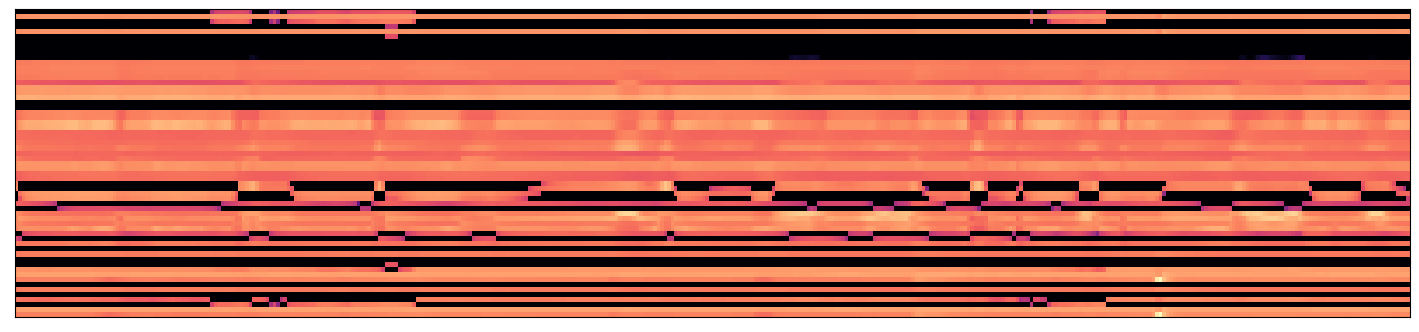

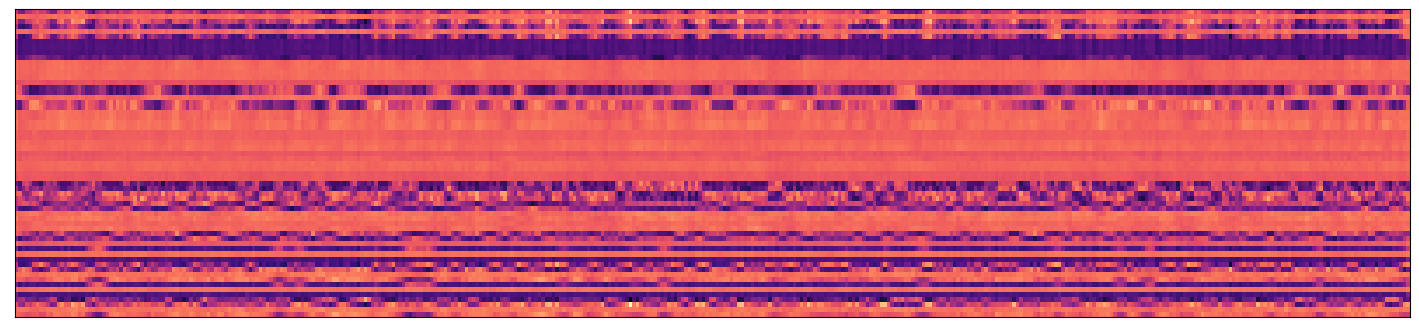

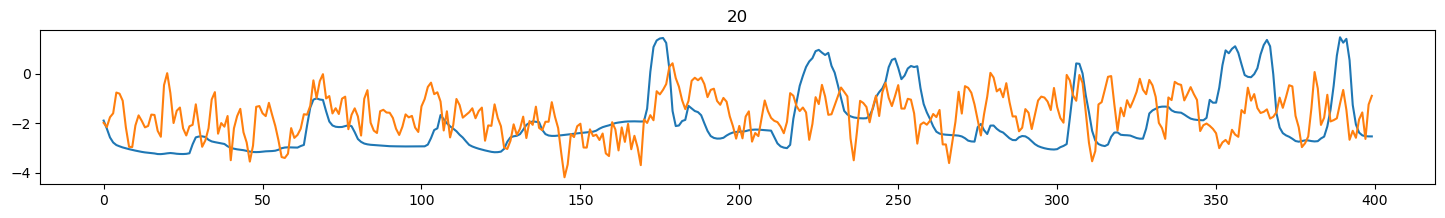

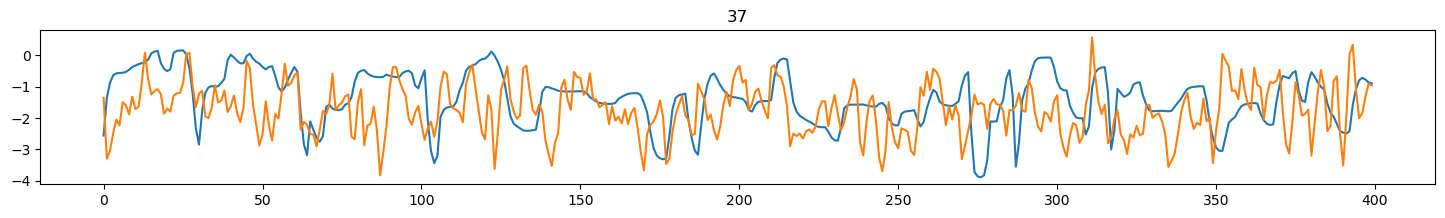

saved /data/scpark/save/lips/train06.27-2/save_17000
17001
loss -0.10163950175046921
17001 -0.10163950175046921
17002
loss -0.021634560078382492
17002 -0.021634560078382492
17003
loss -0.07160240411758423
17003 -0.07160240411758423
17004
loss -0.035236701369285583
17004 -0.035236701369285583
17005
loss -0.06447550654411316
17005 -0.06447550654411316
17006
loss -0.12111890316009521
17006 -0.12111890316009521
17007
loss -0.09830790758132935
17007 -0.09830790758132935
17008
loss -0.08816064894199371
17008 -0.08816064894199371
17009
loss -0.09521842002868652
17009 -0.09521842002868652
17010
loss -0.04012184962630272
17010 -0.04012184962630272
17011
loss -0.0510212704539299
17011 -0.0510212704539299
17012
loss -0.114842988550663
17012 -0.114842988550663
17013
loss -0.10031788796186447
17013 -0.10031788796186447
17014
loss -0.10614089667797089
17014 -0.10614089667797089
17015
loss -0.013557493686676025
17015 -0.013557493686676025
17016
loss -0.06411772966384888
17016 -0.06411772966384888
170

In [ ]:
from IPython import display
import librosa.display
import matplotlib.pyplot as plt

isnan = False
while True:
    if isnan:
        break
    for batch in train_loader:
        inputs = torch.Tensor(batch['mel']).transpose(1, 2).to(device)
        targets = torch.Tensor(batch['blend']).transpose(1, 2).to(device)
        targets = logit(targets)
        
        model.train()
        model.zero_grad()
        outputs = model(targets, inputs)
        
        print(step)
        loss = 0
        for key in outputs.keys():
            if 'loss' in key:
                loss += outputs[key]
                print(key, outputs[key].item())
        if torch.isnan(loss):
            isnan = True
            break
        loss.backward()
        optimizer.step()
        print(step, loss.item())
        
        if step % 100 == 0:
            writer.add_scalar('train_loss', loss.item(), step)
        
        if step % 100 == 0:
            display.clear_output()
            
            losses = []
            for i, batch in enumerate(test_loader):
                if i >= 10:
                    break
                    
                inputs = torch.Tensor(batch['mel']).transpose(1, 2).to(device)
                targets = torch.Tensor(batch['blend']).transpose(1, 2).to(device)
                targets = logit(targets)

                model.eval()
                with torch.no_grad():
                    outputs = model(targets, inputs)
                    
                loss = 0
                for key in outputs.keys():
                    if 'loss' in key:
                        loss += outputs[key]
                print('test :', i, loss.item())
                losses.append(loss)        
            
            test_loss = torch.stack(losses).mean().item()
            print('test_loss :', test_loss)
            writer.add_scalar('test_loss', test_loss, step)
            
            plt.figure(figsize=[18, 4])
            librosa.display.specshow(targets[0].data.cpu().numpy(), cmap='magma')
            plt.show()
            
            model.eval()
            with torch.no_grad():
                y_pred = model.inference(inputs)

            plt.figure(figsize=[18, 4])
            librosa.display.specshow(y_pred[0].data.cpu().numpy(), cmap='magma')
            plt.show()
            
            for i in [20, 37]:
                plt.figure(figsize=[18, 2])
                plt.title(str(i))
                plt.plot(targets[0].data.cpu().numpy()[i])
                plt.plot(y_pred[0].data.cpu().numpy()[i])
                plt.show()

        if step % 1000 == 0:
            save(save_dir, step, model, None, optimizer)
    
        step += 1

In [ ]:
save(save_dir, step, model, None, optimizer)

In [ ]:
print('done')